In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [3]:
root = '/kaggle/input/mvtec-ad'
category = 'bottle'
dataset = os.path.join(root,category)
train_dataset = os.path.join(dataset,'train')
test_dataset = os.path.join(dataset,'test')

In [4]:
#Image processing
transform_func = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_func = transforms.Compose([
transforms.Resize((128,128)),
transforms.ToTensor()
])

In [5]:
#load_dataset
train_dataset = ImageFolder(root=train_dataset,transform=transform_func)
test_dataset = ImageFolder(root=test_dataset,transform=test_transform_func)

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 209
    Root location: /kaggle/input/mvtec-ad/bottle/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 83
    Root location: /kaggle/input/mvtec-ad/bottle/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
#loader
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [9]:
image,label = train_dataset[20]

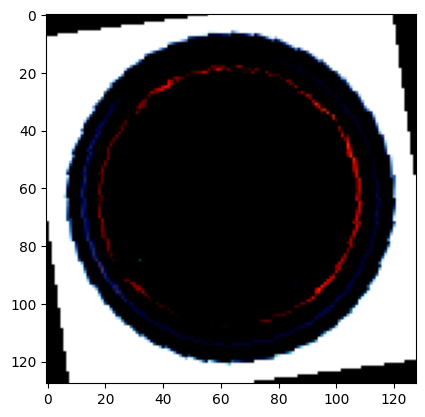

In [10]:
plt.imshow(image.permute(1,2,0).numpy())

In [11]:
#AE
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )
        #Bottleneck
        self.bottleneck = nn.Conv2d(32,64,3,1,1)
        self.decoder = nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16,3,3,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
model = AE().to(device)

In [14]:
model

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
  )
  (bottleneck): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [15]:
#hyperparams
optimizer = optim.Adam(model.parameters(),lr=1e-03)
loss_fn = nn.MSELoss()
epochs=10

In [16]:
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images,_ in train_loader:
        images = images.to(device)
        pred = model(images)
        loss = loss_fn(pred,images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} | Loss: {avg_loss}')

Epoch: 0 | Loss: 2.5271378585270474
Epoch: 1 | Loss: 1.774208392415728
Epoch: 2 | Loss: 1.49379597391401
Epoch: 3 | Loss: 1.4798622982842582
Epoch: 4 | Loss: 1.4754595415932792
Epoch: 5 | Loss: 1.4717637641089303
Epoch: 6 | Loss: 1.4748144149780273
Epoch: 7 | Loss: 1.464066982269287
Epoch: 8 | Loss: 1.4542984451566423
Epoch: 9 | Loss: 1.4459044252123152
